In [1]:
from PIL import Image
from pathlib import Path

# Define source and destination paths
input_root = Path("MRI Scans/Training")
output_root = Path("MRI Scans_augmented/training")

# Define rotation angles
# angles = [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330]
angles = [0, 90, 180, 270]

# Loop through each class folder
for class_folder in input_root.iterdir():
    if class_folder.is_dir():
        class_name = class_folder.name
        output_class_dir = output_root / class_name
        output_class_dir.mkdir(parents=True, exist_ok=True)

        # Process each image in the class folder
        for img_path in class_folder.glob("*.jpg"):
            try:
                image = Image.open(img_path).convert("RGB")
                for angle in angles:
                    # Rotate image
                    rotated = image.rotate(angle, expand=True)
                    
                    # Generate output file name
                    output_name = f"{img_path.stem}_rot{angle}.jpg"
                    rotated.save(output_class_dir / output_name)
            except Exception as e:
                print(f"Error processing {img_path}: {e}")

In [2]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

In [3]:
data_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    # transforms.RandomRotation(degrees=30),
    # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder("MRI Scans_augmented/training", transform=data_transform)
test_dataset = datasets.ImageFolder("MRI Scans/Testing", transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [4]:
resnet = models.resnet50(pretrained=True)

for param in resnet.parameters():
    param.requires_grad = False

g:\My Programming files\Python dev\Machine Learning Project Final Year\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
g:\My Programming files\Python dev\Machine Learning Project Final Year\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
resnet.fc = nn.Sequential(
    nn.Linear(resnet.fc.in_features, 2048),
    nn.LeakyReLU(negative_slope=0.01, inplace=True),
    nn.Dropout(p=0.4),
    nn.Linear(2048, 2048),
    nn.LeakyReLU(negative_slope=0.01, inplace=True),
    nn.Dropout(p=0.4),
    nn.Linear(2048, 4)
)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

resnet = resnet.to(device)

Using device: cuda


In [7]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import torch

# Define class labels and counts (in same order as class_names)
targets = train_loader.dataset.targets
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(targets),
    y=targets
)

# Convert to tensor and send to device
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Create weighted CrossEntropyLoss
criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = torch.optim.AdamW(list(resnet.fc.parameters()), lr=5e-5, weight_decay=1e-3)

In [8]:
best_val_acc = 0
patience = 3
trigger_times = 0


for epoch in range(20):
    resnet.train()
    total_loss = 0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        resnet_out = resnet(images)

        outputs = resnet_out

        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_acc = 100 * correct / total
    train_loss = total_loss / len(train_loader)

    # Validation phase
    resnet.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for val_images, val_labels in test_loader:
            val_images, val_labels = val_images.to(device), val_labels.to(device)

            val_outputs = resnet(val_images)
            loss = criterion(val_outputs, val_labels)

            val_loss += loss.item()
            _, val_predicted = torch.max(val_outputs, 1)
            val_correct += (val_predicted == val_labels).sum().item()
            val_total += val_labels.size(0)

    val_acc = 100 * val_correct / val_total
    val_loss = val_loss / len(test_loader)

    print(f"Epoch {epoch+1}: "
          f"Train Loss = {train_loss:.4f}, Train Acc = {train_acc:.2f}%, "
          f"Val Loss = {val_loss:.4f}, Val Acc = {val_acc:.2f}%")

Epoch 1: Train Loss = 0.4837, Train Acc = 81.43%, Val Loss = 0.5800, Val Acc = 79.80%
Epoch 2: Train Loss = 0.3426, Train Acc = 87.06%, Val Loss = 0.5248, Val Acc = 83.16%
Epoch 3: Train Loss = 0.2909, Train Acc = 88.76%, Val Loss = 0.5229, Val Acc = 84.52%
Epoch 4: Train Loss = 0.2606, Train Acc = 89.96%, Val Loss = 0.5204, Val Acc = 86.20%
Epoch 5: Train Loss = 0.2260, Train Acc = 91.13%, Val Loss = 0.6096, Val Acc = 85.64%
Epoch 6: Train Loss = 0.2069, Train Acc = 92.01%, Val Loss = 0.5273, Val Acc = 87.63%
Epoch 7: Train Loss = 0.1918, Train Acc = 92.56%, Val Loss = 0.5990, Val Acc = 86.76%
Epoch 8: Train Loss = 0.1734, Train Acc = 93.37%, Val Loss = 0.4832, Val Acc = 89.12%
Epoch 9: Train Loss = 0.1596, Train Acc = 93.77%, Val Loss = 0.4968, Val Acc = 90.49%
Epoch 10: Train Loss = 0.1513, Train Acc = 94.14%, Val Loss = 0.5369, Val Acc = 90.24%
Epoch 11: Train Loss = 0.1418, Train Acc = 94.51%, Val Loss = 0.5395, Val Acc = 90.62%
Epoch 12: Train Loss = 0.1321, Train Acc = 94.95%, V

In [9]:
resnet.eval()

num_classes = len(train_loader.dataset.classes)
class_names = train_loader.dataset.classes

class_correct = [0] * num_classes
class_total = [0] * num_classes
total_correct = 0
total_samples = 0

with torch.no_grad():
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = resnet(images)
        _, predicted = torch.max(outputs, 1)

        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)

        for i in range(len(labels)):
            label = labels[i].item()
            pred = predicted[i].item()
            if label == pred:
                class_correct[label] += 1
            class_total[label] += 1

# Total training accuracy
train_accuracy = 100 * total_correct / total_samples
print(f"\nTotal Training Accuracy: {train_accuracy:.2f}%\n")

# Per-class training accuracy
for i in range(num_classes):
    if class_total[i] > 0:
        acc = 100 * class_correct[i] / class_total[i]
        print(f"Training accuracy for class '{class_names[i]}': {acc:.2f}%")
    else:
        print(f"No samples for class '{class_names[i]}'")


Total Training Accuracy: 98.55%

Training accuracy for class 'glioma': 95.54%
Training accuracy for class 'meningioma': 99.27%
Training accuracy for class 'no_tumor': 99.97%
Training accuracy for class 'pituitary': 99.44%


In [10]:
resnet.eval()
num_classes = len(test_loader.dataset.classes)
class_names = test_loader.dataset.classes

class_correct = [0] * num_classes
class_total = [0] * num_classes
total_correct = 0
total_samples = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = resnet(images)
        _, predicted = torch.max(outputs, 1)

        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)

        for i in range(len(labels)):
            label = labels[i].item()
            pred = predicted[i].item()
            if label == pred:
                class_correct[label] += 1
            class_total[label] += 1

total_accuracy = 100 * total_correct / total_samples
print(f"\nTotal Test Accuracy: {total_accuracy:.2f}%\n")

for i in range(num_classes):
    if class_total[i] > 0:
        acc = 100 * class_correct[i] / class_total[i]
        print(f"Accuracy for class '{class_names[i]}': {acc:.2f}%")
    else:
        print(f"No samples for class '{class_names[i]}'")


Total Test Accuracy: 92.60%

Accuracy for class 'glioma': 71.75%
Accuracy for class 'meningioma': 98.78%
Accuracy for class 'no_tumor': 100.00%
Accuracy for class 'pituitary': 95.81%


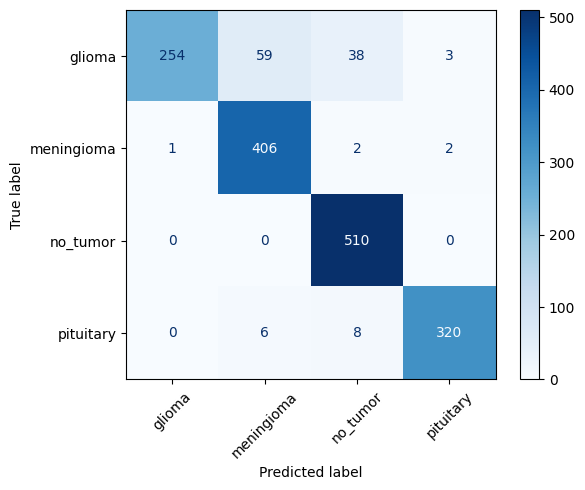

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Collect all predictions and labels
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = resnet(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Create confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', xticks_rotation=45)